In [1]:
import requests 
import tarfile 
import os 
import numpy as np 
import cv2 
import tensorflow as tf
from tensorflow import keras
import imgaug as ia
from imgaug import augmenters as iaa
from typing import List 
import dlib
import zipfile

In [2]:
# define URLs and filenames 
data_url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
training_pairs_url = "http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt"
testing_pairs_url = "http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt"
data_dir_name = 'data'

In [3]:
zip_dataset_name = os.path.basename(data_url)
training_pairs_name = os.path.basename(training_pairs_url)
testing_pairs_name = os.path.basename(testing_pairs_url)


In [4]:
if not os.path.isdir(data_dir_name):
    os.mkdir(data_dir_name)
    print("Downloading data...")
    # Retrieve the data from the given URL 
    r = requests.get(data_url, stream = True)
    with open(os.path.join(data_dir_name, zip_dataset_name), 'wb') as f:
        f.write(r.raw.read())
    print("Downloading data finished")


In [5]:
if not os.path.isfile(training_pairs_name):
  r = requests.get(training_pairs_url)
  with open(training_pairs_name, "wb") as file:
    file.write(r.content)
  print(f"{training_pairs_name} downloaded")
if not os.path.isfile(testing_pairs_name):
  r = requests.get(testing_pairs_url)
  with open(testing_pairs_name, "wb") as file:
    file.write(r.content)
  print(f"{testing_pairs_name} downloaded")

In [6]:
if not os.path.isdir('data/lfw'):
  os.mkdir('data/lfw')
if not len(os.listdir('data/lfw')) >= 5749:
  print("Extracting data...")
  tar = tarfile.open("data/lfw.tgz", "r")
  tar.extractall(data_dir_name)
  tar.close
  print("Finished extracting")


In [10]:
class LfwDataGenerator(keras.utils.Sequence):
    def __init__(self, pairs_file_name, batch_size, anchor_shape = (96, 96), n_channels = 3, img_aug = False, shuffle = True):
        self.pairs_file_name = pairs_file_name
        self.batch_size = batch_size
        
        self.anchor_shape = anchor_shape 
        self.n_channels = n_channels 
        self.img_aug = img_aug 
        self.shuffle = shuffle 
        self.positive_pairs = []
        self.negative_pairs = []
        # process positive and negative pairs 
        with open(pairs_file_name, 'rt') as f:
            for line in f:
                tokens = line.split()
                if len(tokens) == 3:
                    self.positive_pairs.append(
                    [(tokens[0], tokens[1]), (tokens[0], tokens[2])]
                    )
                elif len(tokens) == 4:
                    self.negative_pairs.append(
                    [(tokens[0], tokens[1]), (tokens[2]), (tokens[3])]
                    )
        self.on_epoch_end()
    def on_epoch_end(self):
    # reset indexes  after each epoch 
        self.pos_indexes = np.arange(len(self.positive_pairs))
        self.neg_indexes = np.arange(len(self.negative_pairs))
        if self.shuffle == True:
            np.random.shuffle(self.pos_indexes)
            np.random.shuffle(self.neg_indexes)
        
    def __len__(self):
        # return the number of batches per epoch
        return int(np.floor(len(self.pos_indexes) / self.batch_size))

    def get_image_path(self, name, id):
    # this helper function returns the path to the image of name_id.jpg
        path_name = os.path.join("data/lfw", name)
        return os.path.join(path_name, name) + "_" + f"{id}".zfill(4) + ".jpg"
    
    def augment_images(self, img_batch):
        seq = iaa.Sequential([
            iaa.Crop(px = (0, 16)), 
            iaa.Fliplr(0.5), 
            iaa.GaussianBlur(sigma = (0, 1.0)), 
            # Strengthen or weaken contrast in each image
            iaa.LinearContrast((0.75, 1.5)), # blur images with a sigma of 0 to 3.0
        ])
        return seq(images = img_batch)
    def __getitem__(self, index):
        # slice indexes of batch_size 
        pos_indexes = self.pos_indexes[index * self.batch_size:(index + 1) * self.batch_size]
        neg_indexes = self.neg_indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # init output (numpy) arrays 
        anchor_img_arr = np.empty((self.batch_size, *self.anchor_shape, self.n_channels), dtype = np.float32)
        pos_img_arr = np.empty((self.batch_size, *self.anchor_shape, self.n_channels), dtype = np.float32)
        neg_img_arr = np.empty((self.batch_size, *self.anchor_shape, self.n_channels), dtype = np.float32)
        
        # get the images from name and id from the indexes 
        pos_pairs_batch = [self.positive_pairs[j] for j in pos_indexes]
        neg_pairs_batch = [self.negative_pairs[k] for k in neg_indexes]
        
        for i, pos_pair in enumerate(pos_pairs_batch):
            # process anchor image 
            pos_name, pos_id_1 = pos_pair[0]
            img = cv2.imread(self.get_image_path(pos_name, pos_id_1)).astype('float32')
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.anchor_shape)
            img = img / 255.0
            anchor_img_arr[i,] = img 
            
            # process positive image 
            pos_name, pos_id_2 = pos_pair[1]
            img = cv2.imread(self.get_image_path(pos_name, pos_id_2)).astype('float32')
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.anchor_shape)
            img = img / 255.0
            pos_img_arr[i,] = img 
            
            # process negative image 
            neg_pair = neg_pairs_batch[i]
            neg_name, neg_id = neg_pair[0]
            if pos_name == neg_name:
                neg_name, neg_id = neg_pair[1]
            img = cv2.imread(self.get_image_path(neg_name, neg_id)).astype('float32')
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.anchor_shape)
            img = img / 255.0
            neg_img_arr[i,] = img 
        
        if self.img_aug:
            # apply image augmentation
            anchor_img_arr = self.augment_images(anchor_img_arr)
            pos_img_arr = self.augment_images(pos_img_arr)
            neg_img_arr = self.augment_images(neg_img_arr)
            
        return anchor_img_arr, pos_img_arr, neg_img_arr

In [11]:
batchsize = 4
data_generator = LfwDataGenerator(pairs_file_name = training_pairs_name, batch_size = batchsize, img_aug = False)
print("num of batches: {}".format(len(data_generator)))

num of batches: 275


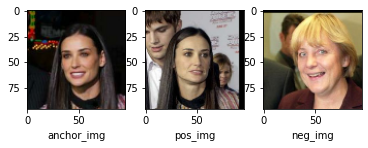

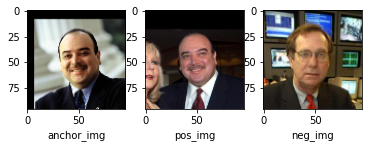

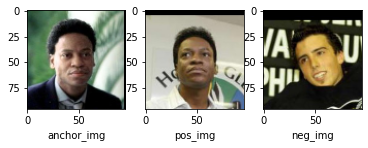

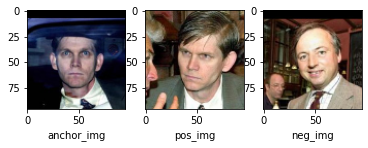

In [12]:
anchor_img_arr, pos_img_arr, neg_img_arr = data_generator[42]
import matplotlib.pyplot as plt 
for i, anchor_img in enumerate(anchor_img_arr):
    anchor_img = anchor_img_arr[i]
    pos_img = pos_img_arr[i]
    neg_img = neg_img_arr[i]
    
    plt.subplot(1, 3, 1)
    plt.imshow(anchor_img)
    plt.xlabel("anchor_img")
    
    plt.subplot(1, 3, 2)
    plt.imshow(pos_img)
    plt.xlabel("pos_img")
    
    plt.subplot(1, 3, 3)
    plt.imshow(neg_img)
    plt.xlabel("neg_img")
    
    plt.show()

In [10]:
batchsize = 4 
aug_data_generator = LfwDataGenerator(pairs_file_name = training_pairs_name, 
                                     batch_size = batchsize, img_aug = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


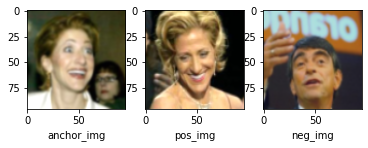

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


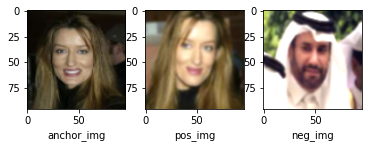

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


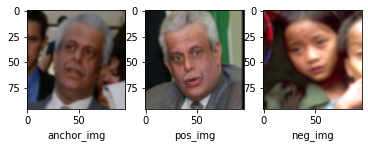

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


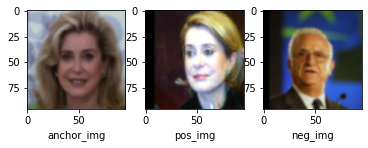

In [11]:
anchor_img_arr, pos_img_arr, neg_img_arr = aug_data_generator[40]
import matplotlib.pyplot as plt 
for i, anchor_img in enumerate(anchor_img_arr):
    anchor_img = anchor_img_arr[i]
    pos_img = pos_img_arr[i]
    neg_img = neg_img_arr[i]
    
    plt.subplot(1, 3, 1)
    plt.imshow(anchor_img)
    plt.xlabel("anchor_img")
    
    plt.subplot(1, 3, 2)
    plt.imshow(pos_img)
    plt.xlabel("pos_img")
    
    plt.subplot(1, 3, 3)
    plt.imshow(neg_img)
    plt.xlabel("neg_img")
    
    plt.show()

In [12]:
batchsize = 4 
training_pairs_name = 'pairsDevTrain.txt'
generator = LfwDataGenerator(pairs_file_name = training_pairs_name, batch_size = batchsize, img_aug = False)
print("num of bacthes: {}".format(len(generator)))

num of bacthes: 275


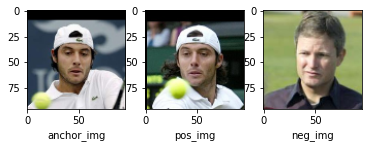

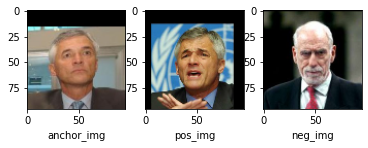

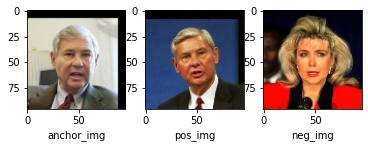

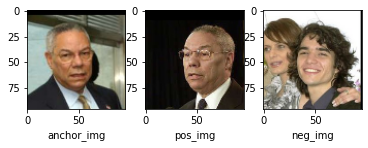

In [13]:
# Displaying the generator
anchor_img_arr, pos_img_arr, neg_img_arr = generator[42] 
import matplotlib.pyplot as plt
for i, anchor_img in enumerate(anchor_img_arr):

    pos_img = pos_img_arr[i]
    neg_img = neg_img_arr[i]
    
    plt.subplot(1, 3, 1)
    plt.imshow(anchor_img)
    plt.xlabel("anchor_img")

    plt.subplot(1, 3, 2)
    plt.imshow(pos_img)
    plt.xlabel("pos_img")

    plt.subplot(1, 3, 3)
    plt.imshow(neg_img)
    plt.xlabel("neg_img")
    
    plt.show()


In [23]:
def get_image_path(self, person, image_file):
    return os.path.join(self.data_dir, person, image_file)